<a href="https://colab.research.google.com/github/stootoon/first-course-rmt/blob/main/Ex1_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random real symmetric matrix $M$

If $M$ is a random real symmetric orthogonal matrix, then its eigenvalues will be real. Any such eigenvalue will satisfy $$ M v = \lambda v.$$ Multiplying both sides by $M^T$ and applying orthogonality and symmetry, we get $$M^T M v = v = \lambda M^T v = \lambda M v \implies Mv = \lambda^{-1} v \implies \lambda = \lambda^{-1} \implies \lambda= \pm 1.$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_rand_sym(N):
  ee = np.sign(np.random.randn(N))
  U = np.linalg.qr(np.random.randn(N, N))[0]
  return U @ np.diag(ee) @ U.T

In [3]:
M = gen_rand_sym(100)

In [4]:
assert np.allclose(M @ M.T, np.eye(M.shape[0])), "M is not orthogonal"
assert np.allclose(M, M.T), "M is not symmetric."

In [5]:
def gen_wigner_sym(N, sd):
  H = np.random.randn(N,N)
  return sd * (H + H.T)/np.sqrt(2*N)

In [6]:
W = gen_wigner_sym(100, 0.1)

## $P_+$ as a projector

As we saw above $M$'s eigenvalues are either +1 or -1. Let $U_+$ be the matrix whose columns are the eigenvectors with +1 eigenvalue, and $U_-$ be the others. These form an orthonormal basis for $R^N$, so we can decompose any vector $v$ as $$ v = U_+ U_+^T v + U_- U_-^T v = U_+ v_+ + U_- v_-.$$ We can write the matrix $M$ in these terms as $$ M = \sum_i U_i U_i^T \lambda_i = U_+ U_+^T - U_- U_-^T.$$  Then $$P_+ v = {1 \over 2} (M + I) v = {1 \over 2} \left((U_+ v_+ - U_- v_-) + (U_+ v_+ + U_- v_-)\right) = U_+ v_+ = U_+ U_+^T v.$$ Hence $P_+$ projects any vector onto the positive eigenspace of $M$. In particular, it sends eigenvectors of $M$ with positive eigenvalues to themselves, and squashes those with negative eigenvalues to 0.

## (a) Histogram of the eigenvalues of E

In [7]:
def gen_E(N, sd):
    M = gen_rand_sym(N)
    X = gen_wigner_sym(N, sd)
    return M + X 

In [48]:
N = 200
sd_vals = [0.1,0.5,1.0]
n_sd = len(sd_vals)
E_samps = [[gen_E(N, sd) for _ in range(101)] for sd in sd_vals]
evals = [[np.linalg.eigvalsh(Ei) for Ei in E_samps[i]] for i in range(n_sd)]

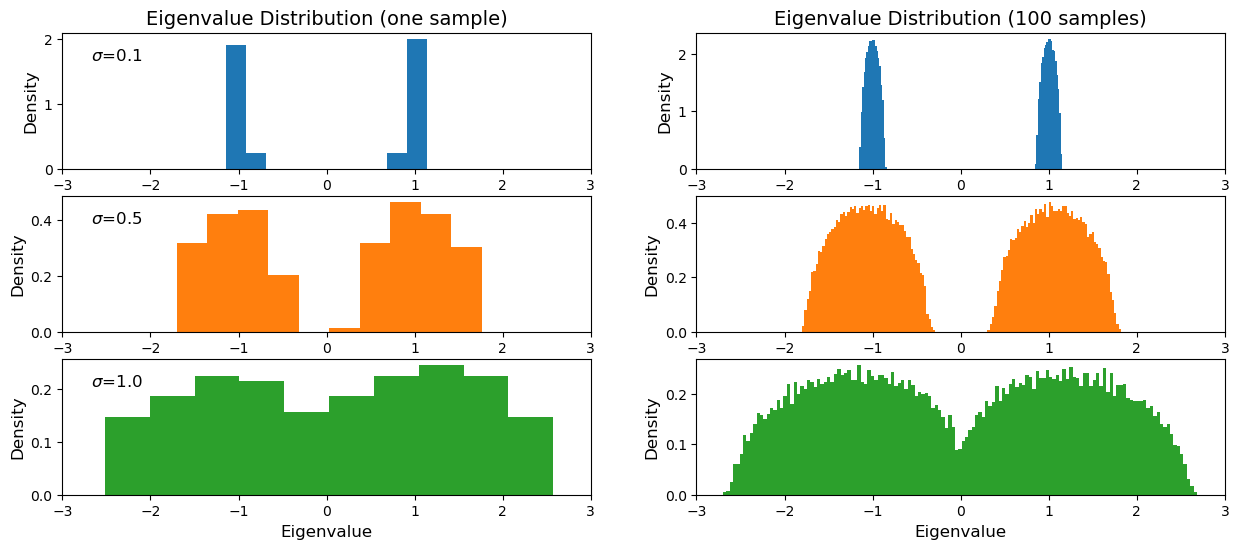

In [49]:
fig, ax = plt.subplots(n_sd, 2, figsize=(15, 2*n_sd))
xl = (-3., 3.)
for i, sd in enumerate(sd_vals):  
    ax[i,0].hist(evals[i][0], bins=10, density=True, label = f"$\\sigma$={sd}", color=f"C{i}")
    ax[i,0].set_xlim(xl)
    ax[i,0].legend(loc="upper left", frameon=False, fontsize=12, handlelength=0)
    ax[i,0].set_ylabel("Density", fontsize=12)
    i == 0 and ax[i,0].set_title("Eigenvalue Distribution (one sample)", fontsize=14)
    e_rest = np.array(evals[i][1:]).flatten()
    ax[i,1].hist(e_rest, bins=int(np.sqrt(len(e_rest))), density=True, color=f"C{i}")
    ax[i,1].set_xlim(xl)
    ax[i,1].set_ylabel("Density", fontsize=12)
    i == 0 and ax[i,1].set_title("Eigenvalue Distribution (100 samples)", fontsize=14)
    i == n_sd - 1 and [ax[i,j].set_xlabel("Eigenvalue", fontsize=12) for j in [0,1]]

## Non-zero density near 0
From the above this seems to occur as $\sigma$ gets close to 1.